In [27]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../train')

import model.models as models
from model.datamodule import MyDataModule
from model.datamodule import MyDataModuleWithRoute
import mylib.route as m_route
import mylib.utils as ut
import mylib.config as conf

In [28]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
DF_PATH = os.path.join(ROOT_PATH, "data", "df_test.pickle")
OUTPUT_DIR = os.path.join(ROOT_PATH, "out")
CONFIG_DIR = os.path.join(ROOT_PATH, "config")

In [29]:
# log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-08-21-11-43-input_route_zero_sumdif")
log_dir = Path(r"C:\Users\hal\Documents\lab\abci\out\lightning_logs\2024-08-21-18-40-mag")
cp_path = os.path.join(log_dir, "cp/last.ckpt")
config_path = os.path.join(log_dir, "config.yaml")

In [30]:
def plot_route(y, y_hat):
    plt.plot(y[0, :, 0], y[0, :, 1], marker="o")
    plt.plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()

In [31]:
def plot_route2(x, y, y_hat):
    # 2つのルートをプロット
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(x[0, :, 3], x[0, :, 4], marker="o")
    ax[1].plot(y[0, :, 0], y[0, :, 1], marker="o", label="true")
    ax[1].plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x", label="pred")
    ax[1].set_xlim(0, 3.5)
    ax[1].set_ylim(0, 11)
    ax[1].legend()
    plt.show()

tensor([[[0.5000, 4.6000],
         [0.9000, 4.7000],
         [1.2000, 5.0000],
         [1.5000, 5.2000],
         [1.7000, 5.4000],
         [1.8000, 5.4000],
         [2.2000, 5.4000],
         [2.4000, 5.4000],
         [2.8000, 5.3000],
         [2.9000, 5.2000],
         [2.9000, 5.1000],
         [2.9000, 4.8000],
         [2.9000, 4.7000],
         [2.9000, 4.6000],
         [2.9000, 4.4000],
         [2.8000, 4.2000],
         [2.5000, 4.1000],
         [2.4000, 4.1000],
         [1.9000, 4.2000],
         [1.6000, 4.4000],
         [1.5000, 4.5000],
         [1.0000, 4.7000],
         [0.9000, 4.7000],
         [0.6000, 4.6000],
         [0.4000, 4.2000],
         [0.2000, 4.0000],
         [0.0000, 3.8000],
         [0.0000, 3.5000],
         [0.2000, 3.2000],
         [0.3000, 3.0000],
         [0.8000, 2.8000],
         [1.3000, 2.6000],
         [1.6000, 2.5000],
         [1.8000, 2.4000],
         [1.9000, 2.3000],
         [2.0000, 2.3000],
         [2.4000, 2.0000],
 

C:\TEMP\ipykernel_19564\1146501332.py:35: UserWarning: Using a target size (torch.Size([1, 40, 2])) that is different to the input size (torch.Size([1, 2])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(y_hat, y.cuda())


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

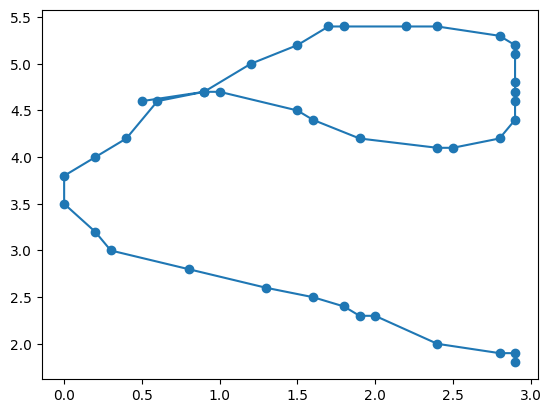

In [33]:

ut.fix_seeds(0)

config = conf.from_yaml(config_path)

df = pickle.load(open(DF_PATH, "rb"))
    
config = conf.from_yaml(config_path)

config_route = config["route"]
route_gen = m_route.DistanceRotateRouteGeneraterV1.from_config(config_route)

config_dm = config["dm"]
# dm = MyDataModuleWithRoute(n_of_route=config_dm["n_of_route"], batch_size=config_dm["batch_size"], route_gen=route_gen, df=df)
dm = MyDataModule(n_of_route=config_dm["n_of_route"], batch_size=config_dm["batch_size"], route_gen=route_gen, df=df)


# model = models.TransformerWithRoute.load_from_checkpoint(cp_path)
model = models.TransformerByPL.load_from_checkpoint(cp_path)
model.eval()


loss_list = []
dist_list = []
for i in range(10):
    # batch = dm.train_dataset[i]
    batch = dm.val_dataset[i]
    x, y = batch
    x = x.unsqueeze(0)
    y = y.unsqueeze(0)
    y_hat = model(x.cuda())
    # print(x)
    print(y)
    print(y_hat)

    loss = nn.functional.mse_loss(y_hat, y.cuda())
    # print(loss)
    loss_list.append(loss.item())

    x = x.cpu().detach().numpy()
    y_hat = y_hat.cpu().detach().numpy()
    y = y.cpu().detach().numpy()
    # plot_route2(x, y, y_hat)
    plot_route(y, y_hat)

    dist_errors = np.linalg.norm(y - y_hat, axis=-1)
    print(dist_errors)
    dist_mean = np.mean(dist_errors)
    
    dist_list.append(dist_mean)  
    print(dist_mean)
    

plt.plot(loss_list)
plt.show()

plt.plot(dist_list)
plt.show()

avg = sum(loss_list) / len(loss_list)
print(avg)


In [14]:
# loss = nn.functional.mse_loss(y_hat, y[:,-1,:].cuda())
print(loss)

plt.figure(figsize=(3, 9))

dist_hist = []

for i in range(len(y)):
    x_s = [y[i, -1, 0].cpu().numpy(), y_hat[i, 0].detach().cpu().numpy()]
    y_s = [y[i, -1, 1].cpu().numpy(), y_hat[i, 1].detach().cpu().numpy()]

    

    dist = pow(pow(x_s[0] - x_s[1], 2) + pow(y_s[0] - y_s[1], 2), 0.5)
    dist_hist.append(dist)

    plt.plot(x_s, y_s, marker="o")


plt.xlim(0, 3)
plt.ylim(0, 10)
plt.show()


plt.hist(dist_hist, bins=30)
plt.show()

tensor(1.4342, device='cuda:0', grad_fn=<MseLossBackward0>)


AttributeError: 'numpy.float32' object has no attribute 'cpu'

<Figure size 300x900 with 0 Axes>

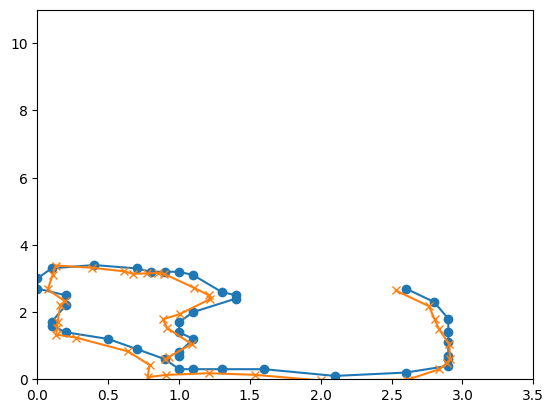

IndexError: index 1 is out of bounds for axis 0 with size 1

In [ ]:
for i in range(10):
    plt.plot(y[i, :, 0], y[i, :, 1], marker="o")
    plt.plot(y_hat[i, :, 0], y_hat[i, :, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()